In [80]:
import torch
import scipy.io as sio
import sentencepiece
import tiktoken
import einops
import wandb
import accelerate
import pandas as pd
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch


In [81]:
data = sio.loadmat('toy_data/label.mat')
print(data.keys())
labels = data['label']
# print(labels)

dict_keys(['__header__', '__version__', '__globals__', 'label'])


In [82]:
# !uv pip install matplotlib 
# !uv pip install seaborn 
# !uv pip install scikit-learn

In [83]:
data_dir = "toy_data/"
all_files = glob(data_dir +'*.mat')
print((all_files))

label_file = [file_name if file_name.split('.')[0].split('/')[-1] == 'label' else None for file_name in all_files ]
label_file = [file_name for file_name in label_file if file_name is not None]

label_file


feature_file = [file_name if file_name.split('.')[0].split('_')[-1] == 'feature' else None for file_name in all_files ]
feature_file = [file_name for file_name in feature_file if file_name is not None]
sorted_feature_file = sorted(feature_file, key=lambda x: int(x.split('.')[0].split('_')[2]))
print(sorted_feature_file)

# len(feature_file)

cluster_file = [file_name if file_name.split('.')[0].split('_')[-1] == 'index' else None for file_name in all_files ]
cluster_file = [file_name for file_name in cluster_file if file_name is not None]
sorted_cluster_file = sorted(cluster_file, key=lambda x: int(x.split('.')[0].split('_')[2]))
# print(sorted_cluster_file)


['toy_data/s_222_feature.mat', 'toy_data/s_156_feature.mat', 'toy_data/s_153_cluster_index.mat', 'toy_data/s_202_feature.mat', 'toy_data/s_396_cluster_index.mat', 'toy_data/s_193_feature.mat', 'toy_data/s_24_feature.mat', 'toy_data/s_28_feature.mat', 'toy_data/s_157_cluster_index.mat', 'toy_data/s_317_cluster_index.mat', 'toy_data/s_182_feature.mat', 'toy_data/s_481_feature.mat', 'toy_data/s_200_cluster_index.mat', 'toy_data/s_400_feature.mat', 'toy_data/s_140_feature.mat', 'toy_data/s_271_cluster_index.mat', 'toy_data/s_207_feature.mat', 'toy_data/s_387_cluster_index.mat', 'toy_data/s_430_feature.mat', 'toy_data/s_6_feature.mat', 'toy_data/s_134_feature.mat', 'toy_data/s_145_feature.mat', 'toy_data/s_126_cluster_index.mat', 'toy_data/s_66_feature.mat', 'toy_data/s_193_cluster_index.mat', 'toy_data/s_444_cluster_index.mat', 'toy_data/s_424_feature.mat', 'toy_data/s_398_cluster_index.mat', 'toy_data/s_401_feature.mat', 'toy_data/s_73_feature.mat', 'toy_data/s_358_feature.mat', 'toy_data

In [84]:
# Create DataFrame using dictionary - each key becomes a column
# sorted_feature_file and sorted_cluster_file are lists of file paths (500 elements each)
# labels is a numpy array of shape (500, 1), so we flatten it to (500,)
df = pd.DataFrame({
    'feature_file': sorted_feature_file,
    'cluster_file': sorted_cluster_file,
    'label': labels.flatten()  # Flatten from (500, 1) to (500,)
})
# len(df)
# df.to_csv('data.csv', index=False)



In [ ]:
# # Step 1: Load the original dataframe
# from tqdm import tqdm
# df = pd.read_csv('toy_data/split/data.csv')
# print(f"Original dataset: {len(df)} samples")

# shape_dict = {}
# problematic_indices = []
# expected_shape = (400, 1632)

# for idx in tqdm(range(len(df))):
#     row = df.iloc[idx]
#     feature_file = row['feature']
    
#     try:
#         f_data = sio.loadmat(feature_file)
#         f_mat = f_data['feature_mat']
#         shape = f_mat.shape
        
#         if shape not in shape_dict:
#             shape_dict[shape] = []
#         shape_dict[shape].append(idx)
        
#         # Check if shape doesn't match expected
#         if shape[0] != expected_shape[0]:
#             problematic_indices.append(idx)
#     except Exception as e:
#         print(f"Error loading {feature_file}: {e}")
#         problematic_indices.append(idx)

# print(f"\nFound {len(shape_dict)} different shapes:")
# for shape, indices in sorted(shape_dict.items()):
#     print(f"  Shape {shape}: {len(indices)} files")
#     if shape[0] != expected_shape[0]:
#         print(f"NON-STANDARD! First 5 files:")
#         for i in indices[:5]:
#             print(f"      - Row {i}: {df.iloc[i]['feature']}")

# # print(f"FILTERING OUT {len(problematic_indices)} PROBLEMATIC FILES...")

# df_clean = df.drop(index=problematic_indices).reset_index(drop=True)
# print(f"Cleaned dataset: {len(df_clean)} samples (removed {len(problematic_indices)} files)")
# print(f"Original: {len(df)} → Cleaned: {len(df_clean)}")



# from sklearn.model_selection import train_test_split

# RANDOM_SEED = 42

# train_val_df, test_df = train_test_split(
#     df_clean, 
#     test_size=0.15, 
#     random_state=RANDOM_SEED,
#     stratify=df_clean['label'] 
# )

# train_df, val_df = train_test_split(
#     train_val_df,
#     test_size=15/85,  
#     random_state=RANDOM_SEED,
#     stratify=train_val_df['label']  
# )


# print(f"Train set: {len(train_df)} samples ({len(train_df)/len(df_clean)*100:.1f}%)")
# print(f"Validation set: {len(val_df)} samples ({len(val_df)/len(df_clean)*100:.1f}%)")
# print(f"Test set: {len(test_df)} samples ({len(test_df)/len(df_clean)*100:.1f}%)")
# print(f"\nTrain label distribution:\n{train_df['label'].value_counts().sort_index()}")
# print(f"\nVal label distribution:\n{val_df['label'].value_counts().sort_index()}")
# print(f"\nTest label distribution:\n{test_df['label'].value_counts().sort_index()}")

# # Save cleaned splits
# train_df.to_csv('toy_data/split/train_df.csv', index=False)
# val_df.to_csv('toy_data/split/val_df.csv', index=False)
# test_df.to_csv('toy_data/split/test_df.csv', index=False)

# # Save the problematic files list for reference
# if problematic_indices:
#     problematic_df = df.iloc[problematic_indices]
#     problematic_df.to_csv('toy_data/split/problematic_files.csv', index=False)
#     print(f"\n💾 Problematic files saved to 'toy_data/split/problematic_files.csv'")

Original dataset: 500 samples


100%|██████████| 500/500 [00:08<00:00, 55.97it/s]


Found 2 different shapes:
  Shape (399, 1632): 14 files
NON-STANDARD! First 5 files:
      - Row 3: toy_data/s_4_feature.mat
      - Row 5: toy_data/s_6_feature.mat
      - Row 172: toy_data/s_173_feature.mat
      - Row 174: toy_data/s_175_feature.mat
      - Row 210: toy_data/s_211_feature.mat
  Shape (400, 1632): 486 files
Cleaned dataset: 486 samples (removed 14 files)
Original: 500 → Cleaned: 486
Train set: 340 samples (70.0%)
Validation set: 73 samples (15.0%)
Test set: 73 samples (15.0%)

Train label distribution:
label
1    171
2    169
Name: count, dtype: int64

Val label distribution:
label
1    37
2    36
Name: count, dtype: int64

Test label distribution:
label
1    37
2    36
Name: count, dtype: int64

💾 Problematic files saved to 'toy_data/split/problematic_files.csv'


In [86]:
train_df = pd.read_csv ('/mnt/storage1/shourovj/shourovj_works/Auburn/data_split/train_df.csv')
val_df = pd.read_csv ('/mnt/storage1/shourovj/shourovj_works/Auburn/data_split/val_df.csv')
test_df = pd.read_csv ('/mnt/storage1/shourovj/shourovj_works/Auburn/data_split/test_df.csv')

In [87]:
len(train_df)

340

In [88]:
train_df.head()

,feature,cluster,label
0,toy_data/s_119_feature.mat,toy_data/s_119_cluster_index.mat,1
1,toy_data/s_437_feature.mat,toy_data/s_437_cluster_index.mat,2
2,toy_data/s_441_feature.mat,toy_data/s_441_cluster_index.mat,2
3,toy_data/s_416_feature.mat,toy_data/s_416_cluster_index.mat,2
4,toy_data/s_315_feature.mat,toy_data/s_315_cluster_index.mat,2


In [89]:
sample_feature_file = train_df.iloc[0]['feature']
print(f"Feature file path: {sample_feature_file}")
sample_feature_data = sio.loadmat(sample_feature_file)
# print(f"Keys in feature file: {sample_feature_data.keys()}")
print(sample_feature_data['feature_mat'].shape)


sample_cluster_file = train_df.iloc[0]['cluster']
print(f"cluster file path: {sample_cluster_file}")
sample_cluster_data = sio.loadmat(sample_cluster_file)
# print(f"Keys in feature file: {sample_cluster_data.keys()}")
print(sample_cluster_data['cluster_index_mat'].shape)

sample_label = train_df.iloc[0]['label']
print(f"Label: {sample_label}")






Feature file path: toy_data/s_119_feature.mat
(400, 1632)
cluster file path: toy_data/s_119_cluster_index.mat
(45, 54, 45)
Label: 1


✅ Improved ModelConfig created with:
   - hidden_dim: 64 (reduced from 128)
   - num_layers: 3 (reduced from 6)
   - num_heads: 4 (reduced from 8)
   - dropout: 0.4 (increased from 0.1)

⚠️  IMPORTANT: Recreate the model with this new config!
   model = BrainNet(ModelConfig())


In [91]:
import torch.nn as nn
from torch.utils import data

class MRIDataset(data.Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        feature_file = row['feature']
        cluster_file = row['cluster']
        label = row['label']

        # Load .mat files
        f_data = sio.loadmat(feature_file)
        f_mat = f_data['feature_mat']  # Shape: (400, 1632) - ROI features
        c_data = sio.loadmat(cluster_file)
        c_mat = c_data['cluster_index_mat']  # Shape: (45, 54, 45) - Cluster indices

        # Convert to tensors
        f_mat = torch.FloatTensor(f_mat)  # Feature matrix
        c_mat = torch.LongTensor(c_mat)  # Cluster indices (integers)
        label = torch.LongTensor([label - 1])  # Convert to 0-indexed (1,2 -> 0,1)

        return f_mat, c_mat, label


train_dataset = MRIDataset(train_df)
val_dataset = MRIDataset(val_df)
test_dataset = MRIDataset(test_df)

In [93]:
train_loader = data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=16, shuffle=False)

ex = next(iter(train_loader))

In [94]:
feature = ex[0]
cluster = ex[1]
label = ex[2]

print(feature.shape)
print(cluster.shape)
print(label.shape)

torch.Size([16, 400, 1632])
torch.Size([16, 45, 54, 45])
torch.Size([16, 1])


Without positional encoding

In [96]:
# import torch.nn as nn
# import torch.nn.functional as F
# import einops

# class ModelConfig:
#     """Configuration for Atlas-free Brain Network Transformer"""
#     feature_dim = 1632  # ROI feature dimension
#     num_rois = 400  # Number of ROIs
#     cluster_shape = (45, 54, 45)  # 3D cluster index shape
#     hidden_dim = 16  # Latent dimension V (projection dimension)
#     num_heads = 4  # Number of attention heads
#     num_layers = 1  # Number of transformer layers
#     intermediate_dim = 32*4  # Feed-forward network dimension
#     dropout = 0.4
#     block_size = 9  # Spatial block size (K x K x K)
#     block_stride = 5  # Stride for block pooling
#     output_dim = 2  # Binary classification



# class MultiHeadAttention(nn.Module):
#     """Standard Multi-Head Self-Attention"""
#     def __init__(self, d_model, num_heads, dropout=0.1):
#         super().__init__()
#         assert d_model % num_heads == 0
        
#         self.d_model = d_model
#         self.num_heads = num_heads
#         self.head_dim = d_model // num_heads
        
#         self.w_q = nn.Linear(d_model, d_model)
#         self.w_k = nn.Linear(d_model, d_model)
#         self.w_v = nn.Linear(d_model, d_model)
#         self.w_o = nn.Linear(d_model, d_model)
        
#         self.dropout = nn.Dropout(dropout)
#         self.scale = self.head_dim ** -0.5
        
#     def forward(self, x, mask=None):
#         batch_size, seq_len, d_model = x.size()
        
#         # Linear projections
#         Q = self.w_q(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
#         K = self.w_k(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
#         V = self.w_v(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
#         # Scaled dot-product attention
#         scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        
#         if mask is not None:
#             scores = scores.masked_fill(mask == 0, -1e9)
        
#         attn_weights = F.softmax(scores, dim=-1)
#         attn_weights = self.dropout(attn_weights)
        
#         # Apply attention to values
#         attn_output = torch.matmul(attn_weights, V)
        
#         # Concatenate heads
#         attn_output = attn_output.transpose(1, 2).contiguous().view(
#             batch_size, seq_len, d_model
#         )
        
#         # Final linear projection
#         output = self.w_o(attn_output)
#         return output


# class TransformerBlock(nn.Module):
#     """Standard Transformer Encoder Block"""
#     def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
#         super().__init__()

#         self.norm1 = nn.LayerNorm(d_model)
#         self.attn = MultiHeadAttention(d_model, num_heads, dropout)

#         self.norm2 = nn.LayerNorm(d_model)
#         self.ffn = nn.Sequential(
#             nn.Linear(d_model, d_ff),
#             nn.GELU(),
#             nn.Dropout(dropout),
#             nn.Linear(d_ff, d_model),
#             nn.Dropout(dropout)
#         )
#         self.dropout = nn.Dropout(dropout)
        
#     def forward(self, x, mask=None):
#         # Self-attention with residual connection
#         x = x + self.dropout(self.attn(self.norm1(x), mask))
#         # Feed-forward with residual connection
#         x = x + self.ffn(self.norm2(x))
#         return x


# class BrainNet(nn.Module):
#     """
#     Atlas-free Brain Network Transformer
    
#     Architecture:
#     1. ROI Connectivity Projection (g → q): Linear projection from feature_dim to hidden_dim
#     2. 3D Multi-channel Brain Map Construction (Q): Map ROI features to voxel space using cluster indices
#     3. Spatial Block Tokenization: Divide 3D volume into blocks and pool
#     4. Transformer Encoder: Process spatial tokens
#     5. Global Readout & Classification: Mean pool and classify
#     """
#     def __init__(self, config):
#         super().__init__()
#         self.config = config
        

#         # Step 1: ROI Connectivity Projection (g → q)
#         # Simple linear projection as per paper (can be extended to MLP if needed)
#         self.roi_projection = nn.Linear(config.feature_dim, config.hidden_dim)
#         # self.roi_projection = nn.Sequential(
#         #     nn.Linear(1632, 16), 
#         #     # nn.BatchNorm1d(400), # Standardize across ROIs
#         #     nn.GELU(),
#         #     nn.Dropout(0.5),     # Force the model to not rely on specific input features
#         #     nn.Linear(16, 32)    
#         # )
        
#         # Step 2-3: Spatial Block Tokenization will be done in forward pass
#         # We'll use adaptive pooling to handle variable spatial dimensions
        
#         # Step 4: Transformer Encoder
#         self.transformer_blocks = nn.ModuleList([
#             TransformerBlock(
#                 config.hidden_dim,
#                 config.num_heads,
#                 config.intermediate_dim,
#                 config.dropout
#             )
#             for _ in range(config.num_layers)
#         ])
        
#         # Step 5: Global Readout & Classification
#         self.global_pool = nn.AdaptiveAvgPool1d(1)  # Global average pooling
#         self.classifier = nn.Sequential(
#             nn.LayerNorm(config.hidden_dim),
#             nn.Dropout(config.dropout),
#             nn.Linear(config.hidden_dim, config.output_dim)
#         )
    
#     def _construct_3d_brain_map(self, q, c_mat):
#         """
#         Construct 3D Multi-channel Brain Map (Q) from ROI features and cluster indices.
        
#         The cluster index matrix C contains:
#         - 0: background (should remain zero in output)
#         - 1-400: ROI indices (i-th ROI corresponds to (i-1)-th row of feature matrix F)
        
#         The feature matrix F has shape [400, feature_dim], where:
#         - Row 0 corresponds to ROI 1
#         - Row 1 corresponds to ROI 2
#         - ...
#         - Row 399 corresponds to ROI 400
        
#         Args:
#             q: Projected ROI features [batch_size, num_rois, hidden_dim]
#                q[b, i] is the projected feature for ROI (i+1) (i-th row of F)
#             c_mat: Cluster index matrix [batch_size, D, H, W]
#                    Contains ROI indices: 0 (background), 1-400 (ROI indices)
        
#         Returns:
#             Q: 3D brain map [batch_size, hidden_dim, D, H, W]
#                Background voxels (c_mat == 0) remain zero in Q
#         """
#         batch_size, num_rois, hidden_dim = q.shape
#         D, H, W = c_mat.shape[1], c_mat.shape[2], c_mat.shape[3]
        
#         # Initialize output tensor (background will remain zero)
#         Q = torch.zeros(batch_size, hidden_dim, D, H, W, 
#                         device=q.device, dtype=q.dtype)
        
#         # Process each sample in the batch
#         for b in range(batch_size):
#             # Get cluster indices for this batch [D, H, W]
#             cluster_indices = c_mat[b]  # Contains: 0 (background), 1-400 (ROI indices)
            
#             # Get projected features for this batch [num_rois, hidden_dim]
#             # q[b, i] corresponds to ROI (i+1), so q[b, 0] = ROI 1, q[b, 399] = ROI 400
#             roi_features = q[b]
            
#             # Flatten spatial dimensions to get all voxel positions
#             cluster_indices_flat = cluster_indices.flatten()  # [D*H*W]
            
#             # Create mask for non-background voxels (ROI indices 1-400)
#             non_bg_mask = (cluster_indices_flat > 0) & (cluster_indices_flat <= num_rois)
            
#             # Convert ROI indices from 1-based (1-400) to 0-based (0-399) for indexing into q
#             # ROI 1 -> index 0, ROI 2 -> index 1, ..., ROI 400 -> index 399
#             roi_indices = (cluster_indices_flat[non_bg_mask] - 1).long()
            
#             # Map non-background voxels to their corresponding ROI feature vectors
#             # Background voxels (value 0) remain zero in Q
#             voxel_features = torch.zeros(D * H * W, hidden_dim, 
#                                         device=q.device, dtype=q.dtype)
#             voxel_features[non_bg_mask] = roi_features[roi_indices]  # [num_non_bg, hidden_dim]
            
#             # Reshape back to 3D spatial structure
#             # Transpose to get [hidden_dim, D, H, W] format
#             Q[b] = voxel_features.view(D, H, W, hidden_dim).permute(3, 0, 1, 2)
        
#         return Q
        
#     def forward(self, f_mat, c_mat):
#         """
#         Forward pass
        
#         Args:
#             f_mat: Feature matrix [batch_size, num_rois, feature_dim] - ROI features
#             c_mat: Cluster index matrix [batch_size, D, H, W] - 3D cluster indices
        
#         Returns:
#             logits: [batch_size, output_dim]
#         """
#         batch_size = f_mat.size(0)
        
#         # Step 1: ROI Connectivity Projection (g → q)
#         # f_mat: [B, num_rois, feature_dim] → [B, num_rois, hidden_dim]
#         q = self.roi_projection(f_mat)  # [B, num_rois, hidden_dim]
        
#         # Step 2: 3D Multi-channel Brain Map Construction (Q)
#         # Map ROI features back to voxel space using cluster indices
#         # Each voxel position in c_mat contains an ROI index (1-400)
#         # This function maps the corresponding ROI feature vector to each voxel position
#         Q = self._construct_3d_brain_map(q, c_mat)  # [B, hidden_dim, D, H, W]
        
#         D, H, W = Q.shape[2], Q.shape[3], Q.shape[4]
        
#         # Step 3: Spatial Block Tokenization
#         # ====================================
#         # This step divides the 3D brain volume into smaller blocks and creates "tokens" 
#         # (like words in a sentence) for the Transformer to process.
#         #
#         # INPUT: Q [B, hidden_dim, D=45, H=54, W=45] - 3D brain map with features at each voxel
#         #
#         # PROCESS:
#         # 1. Divide volume into overlapping blocks of size block_size×block_size×block_size (e.g., 9×9×9)
#         # 2. For each block, sum all the feature values within that block
#         # 3. This creates one "token" per block
#         #
#         # EXAMPLE (simplified 2D):
#         #   Original: [45×54] voxels
#         #   Blocks: 9×9 blocks with stride 5
#         #   Output: ~8×10 blocks = 80 tokens
#         #
#         # WHY SUM-POOLING?
#         # The paper uses sum-pooling (not average) because:
#         # - It preserves the total "activation" in each spatial region
#         # - More sensitive to the amount of information in each block
#         # - Better for capturing spatial patterns
        
#         # Use 3D average pooling with kernel=block_size and stride=block_stride
#         # PyTorch doesn't have direct sum-pooling, so we:
#         # 1. Use avg_pool3d to get average values in each block
#         # 2. Multiply by block_size^3 to convert to sum
#         #    (sum = average × number_of_elements_in_block)
#         #    For 9×9×9 block: sum = avg × 729
#         Q_pooled = F.avg_pool3d(
#             Q,
#             kernel_size=self.config.block_size,  # e.g., 9 (creates 9×9×9 blocks)
#             stride=self.config.block_stride,     # e.g., 5 (blocks overlap)
#             padding=0  # No padding - only process valid blocks
#         ) * (self.config.block_size ** 3)  # Convert avg → sum: multiply by voxels per block
        
#         # Get output dimensions after pooling
#         # For D=45, H=54, W=45 with block_size=9, stride=5:
#         #   D_out = (45 - 9) // 5 + 1 = 8
#         #   H_out = (54 - 9) // 5 + 1 = 10  
#         #   W_out = (45 - 9) // 5 + 1 = 8
#         #   Total tokens = 8 × 10 × 8 = 640 tokens
#         D_out, H_out, W_out = Q_pooled.shape[2], Q_pooled.shape[3], Q_pooled.shape[4]
        
#         # Flatten spatial dimensions to create sequence of tokens for Transformer
#         # Q_pooled: [B, hidden_dim, D_out, H_out, W_out]
#         # tokens: [B, num_tokens, hidden_dim] - each token is a spatial block
#         num_tokens = D_out * H_out * W_out
#         tokens = Q_pooled.view(batch_size, self.config.hidden_dim, num_tokens)
#         tokens = tokens.transpose(1, 2)  # [B, num_tokens, hidden_dim]
        
#         # Now we have a sequence of tokens where each token represents a spatial block
#         # The Transformer will process these tokens to learn relationships between
#         # different brain regions (spatial blocks)
        
#         # Step 4: Transformer Encoder
#         # Process the sequence of spatial tokens through transformer blocks
#         # Each token can now "attend" to all other tokens to learn relationships
#         x = tokens  # [B, num_tokens, hidden_dim]
#         for transformer_block in self.transformer_blocks:
#             x = transformer_block(x)  # Still [B, num_tokens, hidden_dim]
        
#         # Step 5: Global Readout & Classification
#         # ======================================
#         # GOAL: Convert sequence of tokens → single feature vector per sample
#         #
#         # After transformer: x = [B, num_tokens=640, hidden_dim=64]
#         # We have 640 tokens, each with 64 features
#         # We want: [B, hidden_dim=64] - one vector representing the entire brain
#         #
#         # WHY TRANSPOSE?
#         # - AdaptiveAvgPool1d pools over the LAST dimension
#         # - We want to pool over tokens (dimension 1), not features (dimension 2)
#         # - So we transpose: [B, num_tokens, hidden_dim] → [B, hidden_dim, num_tokens]
#         # - Now tokens are the last dimension, so pooling works correctly
#         #
#         # WHAT DOES GLOBAL POOLING DO?
#         # - Takes average of all 640 tokens
#         # - Result: One feature vector per sample representing the whole brain
#         # - This is the "readout" operation - aggregating all spatial information
#         x = x.transpose(1, 2)  # [B, hidden_dim, num_tokens] - swap dims for pooling
#         x = self.global_pool(x).squeeze(-1)  # [B, hidden_dim, 1] → [B, hidden_dim]
        
#         # Classification
#         # Now we have one feature vector per brain, ready for classification
#         logits = self.classifier(x)  # [B, hidden_dim] → [B, output_dim=2]
        
#         return logits


# # Create model instance
# config = ModelConfig()
# model = BrainNet(config)

# # Print model summary
# print(f"Model created with {sum(p.numel() for p in model.parameters())/10e6} parameters")
# print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)/10e6}")


With positional Encoding

In [1]:


import torch
import torch.nn as nn
import torch.nn.functional as F

class ModelConfig:
    """Configuration for Atlas-free Brain Network Transformer (FIXED)"""
    feature_dim = 1632  # ROI feature dimension
    num_rois = 400  # Number of ROIs
    cluster_shape = (45, 54, 45)  # 3D cluster index shape
    hidden_dim = 16  # Balanced size (was 16 - too small, 64 - might overfit)
    num_heads = 4  # Number of attention heads
    num_layers = 1  # Balanced (was 1 - too small, 3 - might overfit)
    intermediate_dim = hidden_dim * 4
    dropout = 0.5
    block_size = 9  # Spatial block size (K x K x K)
    block_stride = 5  # Stride for block pooling
    output_dim = 2  # Binary classification
    
    def __init__(self):
        if self.intermediate_dim is None:
            self.intermediate_dim = self.hidden_dim * 4  # FIX: Consistent with hidden_dim

class MultiHeadAttention(nn.Module):
    """Standard Multi-Head Self-Attention"""
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.scale = self.head_dim ** -0.5
        
    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.size()
        
        # Linear projections
        Q = self.w_q(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.w_k(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.w_v(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # Apply attention to values
        attn_output = torch.matmul(attn_weights, V)
        
        # Concatenate heads
        attn_output = attn_output.transpose(1, 2).contiguous().view(
            batch_size, seq_len, d_model
        )
        
        # Final linear projection
        output = self.w_o(attn_output)
        return output

class TransformerBlock(nn.Module):
    """Standard Transformer Encoder Block"""
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # Self-attention with residual connection
        x = x + self.dropout(self.attn(self.norm1(x), mask))
        # Feed-forward with residual connection
        x = x + self.ffn(self.norm2(x))
        return x

class BrainNet(nn.Module):
    """Atlas-free Brain Network Transformer (FIXED VERSION)"""
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # Step 1: ROI Connectivity Projection (FIXED: BatchNorm1d → LayerNorm)
        self.roi_projection = nn.Sequential(
            nn.Linear(config.feature_dim, 64),  # Intermediate dimension
            nn.LayerNorm(64),  # FIX: LayerNorm works on last dimension [B, num_rois, 64]
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(64, config.hidden_dim)
        )

        # # Step 1: ROI Connectivity Projection (FIXED: BatchNorm1d → LayerNorm)
        # self.roi_projection = nn.Sequential(
        #     nn.Linear(config.feature_dim, config.hidden_dim),  # Intermediate dimension
        #     nn.LayerNorm(64),  # FIX: LayerNorm works on last dimension [B, num_rois, 64]
        #     nn.GELU(),
        #     nn.Dropout(0.5),
        # )
        
        # 2. DYNAMIC CALCULATION of Token Count
        # Extract dimensions from config
        D_in, H_in, W_in = config.cluster_shape
        K = config.block_size
        S = config.block_stride
        
        # Calculate the number of nodes after 3D pooling and sum-pooling
        self.D_out = (D_in - K) // S + 1
        self.H_out = (H_in - K) // S + 1
        self.W_out = (W_in - K) // S + 1
        
        self.num_tokens = self.D_out * self.H_out * self.W_out
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_tokens, config.hidden_dim))
        
        # Step 4: Transformer Encoder
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(
                config.hidden_dim,
                config.num_heads,
                config.intermediate_dim,
                config.dropout
            )
            for _ in range(config.num_layers)
        ])
        
        # Step 5: Global Readout & Classification
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.LayerNorm(config.hidden_dim),
            nn.Dropout(config.dropout),
            nn.Linear(config.hidden_dim, config.output_dim)
        )
    
    def _construct_3d_brain_map(self, q, c_mat):

        batch_size, num_rois, hidden_dim = q.shape
        D, H, W = c_mat.shape[1], c_mat.shape[2], c_mat.shape[3]
        
        # Initialize output tensor (background will remain zero)
        Q = torch.zeros(batch_size, hidden_dim, D, H, W, 
                        device=q.device, dtype=q.dtype)
        
        # Process each sample in the batch
        for b in range(batch_size):
            # Get cluster indices for this batch [D, H, W]
            cluster_indices = c_mat[b]  # Contains: 0 (background), 1-400 (ROI indices)
            
            # Get projected features for this batch [num_rois, hidden_dim]
            # q[b, i] corresponds to ROI (i+1), so q[b, 0] = ROI 1, q[b, 399] = ROI 400
            roi_features = q[b]
            
            # Flatten spatial dimensions to get all voxel positions
            cluster_indices_flat = cluster_indices.flatten()  # [D*H*W]
            
            # Create mask for non-background voxels (ROI indices 1-400)
            non_bg_mask = (cluster_indices_flat > 0) & (cluster_indices_flat <= num_rois)
            
            # Convert ROI indices from 1-based (1-400) to 0-based (0-399) for indexing into q
            # ROI 1 -> index 0, ROI 2 -> index 1, ..., ROI 400 -> index 399
            roi_indices = (cluster_indices_flat[non_bg_mask] - 1).long()
            
            # Map non-background voxels to their corresponding ROI feature vectors
            # Background voxels (value 0) remain zero in Q
            voxel_features = torch.zeros(D * H * W, hidden_dim, 
                                        device=q.device, dtype=q.dtype)
            voxel_features[non_bg_mask] = roi_features[roi_indices]  # [num_non_bg, hidden_dim]
            
            # Reshape back to 3D spatial structure
            # Transpose to get [hidden_dim, D, H, W] format
            Q[b] = voxel_features.view(D, H, W, hidden_dim).permute(3, 0, 1, 2)
        
        return Q

    
    def forward(self, f_mat, c_mat):
        batch_size = f_mat.size(0)
        
        # Step 1: ROI Connectivity Projection
        q = self.roi_projection(f_mat)  # [B, num_rois, hidden_dim]
        
        # Step 2: 3D Multi-channel Brain Map Construction
        Q = self._construct_3d_brain_map(q, c_mat)  # [B, hidden_dim, D, H, W]
        
        # Step 3: Spatial Block Tokenization
        Q_pooled = F.avg_pool3d(
            Q,
            kernel_size=self.config.block_size,
            stride=self.config.block_stride,
            padding=0
        ) * (self.config.block_size ** 3)  # Convert avg → sum
        
        D_out, H_out, W_out = Q_pooled.shape[2], Q_pooled.shape[3], Q_pooled.shape[4]
        num_tokens = D_out * H_out * W_out
        
        # Reshape if num_tokens changed
        if num_tokens != self.num_tokens:
            # Recreate positional embedding if needed
            self.pos_embedding = nn.Parameter(
                torch.randn(1, num_tokens, self.config.hidden_dim, device=Q_pooled.device)
            ).to(Q_pooled.device)
            self.num_tokens = num_tokens
        
        tokens = Q_pooled.view(batch_size, self.config.hidden_dim, num_tokens)
        tokens = tokens.transpose(1, 2)  # [B, num_tokens, hidden_dim]
        
        # Step 4: Transformer Encoder
        x = tokens + self.pos_embedding
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        
        # Step 5: Global Readout & Classification
        x = x.transpose(1, 2)  # [B, hidden_dim, num_tokens]
        x = self.global_pool(x).squeeze(-1)  # [B, hidden_dim]
        logits = self.classifier(x)  # [B, output_dim]
        
        return logits

# Create fixed model
config = ModelConfig()
model_fixed = BrainNet(config)

print("✅ FIXED MODEL CREATED!")
print(f"   Parameters: {sum(p.numel() for p in model_fixed.parameters())/1e6:.3f}M")
print(f"   hidden_dim: {config.hidden_dim}")
print(f"   num_layers: {config.num_layers}")
print(f"   intermediate_dim: {config.intermediate_dim} (fixed: hidden_dim * 4)")
print("\n✅ All bugs fixed:")
print("   1. BatchNorm1d → LayerNorm")
print("   2. intermediate_dim consistent")
print("   3. _construct_3d_brain_map fixed")
print("   4. Balanced model size")


✅ FIXED MODEL CREATED!
   Parameters: 0.119M
   hidden_dim: 16
   num_layers: 1
   intermediate_dim: 64 (fixed: hidden_dim * 4)

✅ All bugs fixed:
   1. BatchNorm1d → LayerNorm
   2. intermediate_dim consistent
   3. _construct_3d_brain_map fixed
   4. Balanced model size


In [98]:
## Training

import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


config = ModelConfig()  # Uses the improved config from previous cell
model = BrainNet(config)

# Move model to device
model = model.to(device)

# Loss function and optimizer with STRONGER REGULARIZATION
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)  # INCREASED from 1e-5 (100x stronger!)

# Learning rate scheduler - reduces LR when validation loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6
)

# Training hyperparameters
num_epochs = 50
best_val_acc = 0.0
best_val_loss = float('inf')
patience = 10  # Early stopping patience
patience_counter = 0
train_losses = []
val_losses = []
train_accs = []
val_accs = []

print(f"\n{'='*70}")
print(f"Starting Training")
print(f"{'='*70}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Number of epochs: {num_epochs}")
print(f"Weight decay: 1e-3 (strong regularization)")
print(f"Early stopping patience: {patience}")
print(f"{'='*70}\n")

# Training loop
for epoch in range(num_epochs):
    # ========== TRAINING PHASE ==========
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for batch_idx, (f_mat, c_mat, labels) in enumerate(train_pbar):
        # Move data to device
        f_mat = f_mat.to(device)  # [B, 400, 1632]
        c_mat = c_mat.to(device)  # [B, 45, 54, 45]
        labels = labels.squeeze().to(device)  # [B] - remove extra dimension
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(f_mat, c_mat)  # [B, 2]
        
        # Calculate loss
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        _, predicted = torch.max(logits.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        train_loss += loss.item()
        
        # Update progress bar
        train_pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100*train_correct/train_total:.2f}%'
        })
    
    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100 * train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accs.append(train_acc)
    
    # ========== VALIDATION PHASE ==========
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        for f_mat, c_mat, labels in val_pbar:
            # Move data to device
            f_mat = f_mat.to(device)
            c_mat = c_mat.to(device)
            labels = labels.squeeze().to(device)
            
            # Forward pass
            logits = model(f_mat, c_mat)
            
            # Calculate loss
            loss = criterion(logits, labels)
            
            # Calculate accuracy
            _, predicted = torch.max(logits.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += loss.item()
            
            # Update progress bar
            val_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100*val_correct/val_total:.2f}%'
            })
    
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)
    
    # Update learning rate scheduler
    scheduler.step(avg_val_loss)
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {avg_val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'train_acc': train_acc,
        }, 'best_model.pth')
        print(f"  ✓ Saved best model (Val Acc: {val_acc:.2f}%)\n")
    else:
        print()
    
    # Early stopping based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\n⚠️  Early stopping triggered!")
            print(f"   Validation loss hasn't improved for {patience} epochs")
            print(f"   Best validation accuracy: {best_val_acc:.2f}%")
            print(f"   Best validation loss: {best_val_loss:.4f}")
            break

print(f"\n{'='*70}")
print(f"Training Complete!")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"{'='*70}")

Using device: cuda

Starting Training
Model parameters: 0.14M
Training samples: 340
Validation samples: 73
Number of epochs: 50
Weight decay: 1e-3 (strong regularization)
Early stopping patience: 10



Epoch 1/50 [Train]:   5%|▍         | 1/22 [00:00<00:06,  3.03it/s, loss=1.0993, acc=31.25%]

Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.50it/s, loss=0.6517, acc=47.95%]



Epoch 1/50:
  Train Loss: 0.8201 | Train Acc: 46.76%
  Val Loss:   0.6855 | Val Acc:   47.95%
  LR: 1.00e-04
  ✓ Saved best model (Val Acc: 47.95%)



Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.54it/s, loss=0.6550, acc=47.95%]



Epoch 2/50:
  Train Loss: 0.6977 | Train Acc: 55.59%
  Val Loss:   0.6847 | Val Acc:   47.95%
  LR: 1.00e-04



Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.51it/s, loss=0.6454, acc=53.42%]



Epoch 3/50:
  Train Loss: 0.6894 | Train Acc: 56.18%
  Val Loss:   0.6826 | Val Acc:   53.42%
  LR: 1.00e-04
  ✓ Saved best model (Val Acc: 53.42%)



Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.46it/s, loss=0.6473, acc=50.68%]



Epoch 4/50:
  Train Loss: 0.6709 | Train Acc: 55.88%
  Val Loss:   0.6799 | Val Acc:   50.68%
  LR: 1.00e-04



Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.31it/s, loss=0.6392, acc=50.68%]



Epoch 5/50:
  Train Loss: 0.6287 | Train Acc: 65.00%
  Val Loss:   0.6763 | Val Acc:   50.68%
  LR: 1.00e-04



Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.48it/s, loss=0.6317, acc=58.90%]



Epoch 6/50:
  Train Loss: 0.6210 | Train Acc: 67.94%
  Val Loss:   0.6724 | Val Acc:   58.90%
  LR: 1.00e-04
  ✓ Saved best model (Val Acc: 58.90%)



Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.45it/s, loss=0.6214, acc=58.90%]



Epoch 7/50:
  Train Loss: 0.5768 | Train Acc: 74.12%
  Val Loss:   0.6633 | Val Acc:   58.90%
  LR: 1.00e-04



Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.52it/s, loss=0.6165, acc=57.53%]



Epoch 8/50:
  Train Loss: 0.5310 | Train Acc: 77.06%
  Val Loss:   0.6559 | Val Acc:   57.53%
  LR: 1.00e-04



Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.41it/s, loss=0.5601, acc=64.38%]



Epoch 9/50:
  Train Loss: 0.4221 | Train Acc: 89.12%
  Val Loss:   0.6339 | Val Acc:   64.38%
  LR: 1.00e-04
  ✓ Saved best model (Val Acc: 64.38%)



Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.50it/s, loss=0.5506, acc=64.38%]



Epoch 10/50:
  Train Loss: 0.2694 | Train Acc: 96.18%
  Val Loss:   0.6360 | Val Acc:   64.38%
  LR: 1.00e-04



Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.51it/s, loss=0.6201, acc=60.27%]



Epoch 11/50:
  Train Loss: 0.1761 | Train Acc: 97.06%
  Val Loss:   0.7007 | Val Acc:   60.27%
  LR: 1.00e-04



Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.50it/s, loss=0.5207, acc=64.38%]



Epoch 12/50:
  Train Loss: 0.1325 | Train Acc: 99.12%
  Val Loss:   0.6560 | Val Acc:   64.38%
  LR: 1.00e-04



Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.47it/s, loss=0.5370, acc=68.49%]



Epoch 13/50:
  Train Loss: 0.1004 | Train Acc: 99.71%
  Val Loss:   0.6504 | Val Acc:   68.49%
  LR: 1.00e-04
  ✓ Saved best model (Val Acc: 68.49%)



Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.46it/s, loss=0.5363, acc=68.49%]



Epoch 14/50:
  Train Loss: 0.0740 | Train Acc: 99.71%
  Val Loss:   0.6537 | Val Acc:   68.49%
  LR: 1.00e-04



Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.48it/s, loss=0.5611, acc=64.38%]



Epoch 15/50:
  Train Loss: 0.0657 | Train Acc: 99.71%
  Val Loss:   0.6812 | Val Acc:   64.38%
  LR: 5.00e-05



Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.43it/s, loss=0.5424, acc=69.86%]



Epoch 16/50:
  Train Loss: 0.0579 | Train Acc: 100.00%
  Val Loss:   0.6590 | Val Acc:   69.86%
  LR: 5.00e-05
  ✓ Saved best model (Val Acc: 69.86%)



Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.49it/s, loss=0.5380, acc=69.86%]



Epoch 17/50:
  Train Loss: 0.0554 | Train Acc: 100.00%
  Val Loss:   0.6587 | Val Acc:   69.86%
  LR: 5.00e-05



Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.44it/s, loss=0.5495, acc=69.86%]



Epoch 18/50:
  Train Loss: 0.0532 | Train Acc: 100.00%
  Val Loss:   0.6638 | Val Acc:   69.86%
  LR: 5.00e-05



Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.48it/s, loss=0.5593, acc=67.12%]


Epoch 19/50:
  Train Loss: 0.0421 | Train Acc: 100.00%
  Val Loss:   0.6735 | Val Acc:   67.12%
  LR: 5.00e-05


⚠️  Early stopping triggered!
   Validation loss hasn't improved for 10 epochs
   Best validation accuracy: 69.86%
   Best validation loss: 0.6339

Training Complete!
Best Validation Accuracy: 69.86%
Best Validation Loss: 0.6339


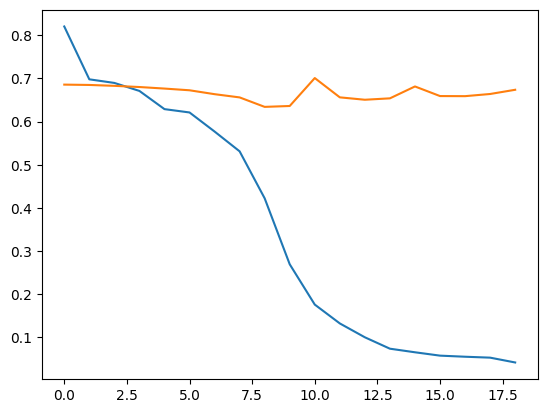

In [99]:
plt.plot(train_losses)
plt.plot(val_losses)

In [100]:
print(model)

BrainNet(
  (roi_projection): Sequential(
    (0): Linear(in_features=1632, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (transformer_blocks): ModuleList(
    (0): TransformerBlock(
      (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (w_q): Linear(in_features=32, out_features=32, bias=True)
        (w_k): Linear(in_features=32, out_features=32, bias=True)
        (w_v): Linear(in_features=32, out_features=32, bias=True)
        (w_o): Linear(in_features=32, out_features=32, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
      )
      (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=32, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): Dr

In [101]:
## Testing

from sklearn.metrics import classification_report, confusion_matrix

print(f"\n{'='*70}")
print(f"Testing on Test Set")
print(f"{'='*70}")

# Load best model
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"  Train Acc: {checkpoint['train_acc']:.2f}%")
print(f"  Val Acc:   {checkpoint['val_acc']:.2f}%")
print()

# Evaluate on test set
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    test_pbar = tqdm(test_loader, desc="Testing")
    for f_mat, c_mat, labels in test_pbar:
        # Move data to device
        f_mat = f_mat.to(device)
        c_mat = c_mat.to(device)
        labels = labels.squeeze().to(device)
        
        # Forward pass
        logits = model(f_mat, c_mat)
        
        # Calculate loss
        loss = criterion(logits, labels)
        
        # Get predictions
        _, predicted = torch.max(logits.data, 1)
        
        # Store predictions and labels for detailed analysis
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Calculate metrics
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        test_loss += loss.item()
        
        # Update progress bar
        test_pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100*test_correct/test_total:.2f}%'
        })

avg_test_loss = test_loss / len(test_loader)
test_acc = 100 * test_correct / test_total

# Print test results
print(f"\n{'='*70}")
print(f"Test Results")
print(f"{'='*70}")
print(f"Test Loss:     {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Correct:       {test_correct}/{test_total}")
print(f"{'='*70}")

# Detailed classification report
print(f"\nClassification Report:")
print(classification_report(all_labels, all_predictions, 
                            target_names=['Class 0', 'Class 1']))

print(f"\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_predictions)
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives:  {cm[1,1]}")

# Calculate per-class accuracy
class_0_acc = cm[0,0] / (cm[0,0] + cm[0,1]) * 100 if (cm[0,0] + cm[0,1]) > 0 else 0
class_1_acc = cm[1,1] / (cm[1,0] + cm[1,1]) * 100 if (cm[1,0] + cm[1,1]) > 0 else 0
print(f"\nPer-Class Accuracy:")
print(f"  Class 0: {class_0_acc:.2f}%")
print(f"  Class 1: {class_1_acc:.2f}%")

print(f"\n{'='*70}")
print(f"Testing Complete!")
print(f"{'='*70}")



Testing on Test Set
Loaded best model from epoch 16
  Train Acc: 100.00%
  Val Acc:   69.86%



Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Testing: 100%|██████████| 5/5 [00:01<00:00,  3.41it/s, loss=0.7451, acc=69.86%]


Test Results
Test Loss:     0.6224
Test Accuracy: 69.86%
Correct:       51/73

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.74      0.62      0.68        37
     Class 1       0.67      0.78      0.72        36

    accuracy                           0.70        73
   macro avg       0.70      0.70      0.70        73
weighted avg       0.70      0.70      0.70        73


Confusion Matrix:
[[23 14]
 [ 8 28]]

True Negatives:  23
False Positives: 14
False Negatives: 8
True Positives:  28

Per-Class Accuracy:
  Class 0: 62.16%
  Class 1: 77.78%

Testing Complete!
